<a href="https://colab.research.google.com/github/worldone-web/Team4-Traveler/blob/main/BPRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [2]:
import torch
import numpy as np
import pandas as pd
import random

In [3]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("PyTorch version:", torch.__version__)

CUDA available: True
CUDA version: 12.1
PyTorch version: 2.5.0+cu121


In [5]:
root_path = '/content/drive/MyDrive/G_Project/'

train_checkin = root_path + 'train.csv'
test_checkin = root_path + 'test.csv'
test_negative = root_path + 'negative.csv'

## 데이터 생성

In [6]:
df = pd.read_csv(root_path + "philadelphia_checkin_small.csv")
df.head()

,newUserId,newBusinessId
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


### split_train_test

In [7]:
# 각 사용자별로 n번째 음식점 방문기록 까지 데이터를 테스트 데이터로, 나머지를 트레이닝 데이터로 분리하는 함수
def split_train_test_data(df, n=3, user_col='newUserId', item_col='newBusinessId', output_dir='.'):
    train_data = []
    test_data = []

    # 사용자별로 그룹화하여 처리
    for user_id, group in df.groupby(user_col):
        # 첫 번째부터 n번째 음식점 방문 기록을 test_data로 추가
        test_data.extend(group.iloc[:n].values.tolist())

        # n+1번째부터 마지막 음식점 방문 기록을 train_data로 추가
        train_data.extend(group.iloc[n:].values.tolist())

    train_df = pd.DataFrame(train_data, columns=[user_col, item_col])
    test_df = pd.DataFrame(test_data, columns=[user_col, item_col])


    train_size = train_df.shape
    test_size = test_df.shape
    print("Train 데이터 크기:", train_size)
    print("Test 데이터 크기:", test_size)
    print("Test 데이터 크기 / Train 데이터 크기 비율:", test_size[0] / train_size[0]) # 전체 크기의 대략 10%

    # CSV 파일로 저장
    train_df.to_csv(output_dir + "train.csv", index=False, header=False, sep='\t')
    test_df.to_csv(output_dir + "test.csv", index=False, header=False, sep='\t')

    print("'train.csv'와 'test.csv' 파일이 생성되었습니다.")

split_train_test_data(df, n=3, output_dir=root_path)

Train 데이터 크기: (296794, 2)
Test 데이터 크기: (36185, 2)
Test 데이터 크기 / Train 데이터 크기 비율: 0.12191958058451316
'train.csv'와 'test.csv' 파일이 생성되었습니다.


### generate_negative

In [8]:
# 각 사용자별로 부정적인 조합 생성
def generate_negative_samples(df, n=100, user_col='newUserId', item_col='newBusinessId', output_dir='.'):
    # 사용자와 음식점 집합 구하기
    users = df[user_col].unique()
    businesses = df[item_col].unique()

    # 사용자별로 부정적인 조합 저장
    user_negative_samples = {}

    # 각 사용자에 대해 부정적인 조합 생성
    for user in users:
        # 사용자가 방문한 음식점 집합
        user_visited_businesses = set(df[df[user_col] == user][item_col].unique())

        # 사용자가 방문하지 않은 음식점 찾기
        user_not_visited_businesses = list(set(businesses) - user_visited_businesses)

        # 랜덤 샘플링하여 부정적인 조합 생성
        if len(user_not_visited_businesses) > n: #n개 이상이면 데이터가 많아지니 제한을 둠
            user_negative_samples[user] = random.sample(user_not_visited_businesses, n)
        else:
            user_negative_samples[user] = user_not_visited_businesses

    # 부정적인 조합을 CSV 파일로 저장
    with open(output_dir+ "negative.csv", 'w') as f:
        for user, negatives in user_negative_samples.items():
            f.write(f"{user},{','.join(map(str, negatives))}\n")

    print("파일 'negative.csv'가 생성되었습니다.")

generate_negative_samples(df, n=100, output_dir=root_path)

파일 'negative.csv'가 생성되었습니다.


### generate_individual_negative

In [ ]:
# 개인별로 방문하지 않은 음식점 샘플링
def generate_individual_negative_sample(df, user_id, n=100, user_col='newUserId', item_col='newBusinessId'):
    # 모든 음식점 목록 가져오기
    businesses = df[item_col].unique()
    # 사용자가 방문한 음식점 목록 가져오기
    user_visited_businesses = set(df[df[user_col] == user_id][item_col].unique())
    # 사용자가 방문하지 않은 음식점 목록 계산
    user_not_visited_businesses = list(set(businesses) - user_visited_businesses)
    # 방문하지 않은 음식점 중에서 n개를 랜덤으로 샘플링
    if len(user_not_visited_businesses) > n:
        random_negative = random.sample(user_not_visited_businesses, n)
    else:
        random_negative = user_not_visited_businesses
    return random_negative


# testData를 위한 부정적인 음식점 샘플링
with open(root_path + 'negative.csv', 'r') as negative_file \
  , open(root_path + 'test.csv', 'r') as test_file \
  , open(root_path + 'test_negative.csv', 'w') as test_negative_file:
    read_negative = negative_file.readlines()
    read_test = test_file.readlines()
    print(len(read_negative))  # 12062 -> 사용자 수만큼 개인별로 방문하지 않은 음식점 집합 완성

    for i in range(len(read_negative)):  # 각 사용자에 대해
        negative = read_negative[i]  # 사용자 i에 대한 방문하지 않은 음식점 집합 가져오기
        user_id, user_id_negative_businesses = negative.strip().split(',', 1)  # 사용자 ID와 방문하지 않은 음식점 구분
        #user_id_negative_businesses = user_id_negative_businesses.split(',')  # 방문하지 않은 음식점들을 리스트로 분리

        for j in range(i * 3, (i + 1) * 3):  # 각 사용자의 3개의 음식점 방문기록
            test = read_test[j % len(read_test)]  # 테스트 데이터 중 해당 사용자의 음식점 방문기록
            user_trip = test.strip()  # 공백 제거

            # 개별 사용자의 부정적인 음식점 생성
            individual_negative_sample = generate_individual_negative_sample(df, int(user_id), n=100)

            # 테스트 데이터와 부정적인 샘플을 결합하여 git에 있는 BPR모델 입력에 맞게 변환
            test_negative_business = user_trip + '\t' + '\t'.join(map(str, individual_negative_sample)) + '\n'
            test_negative_file.write(test_negative_business)

print("파일 'test_negative.csv'가 생성되었습니다.")

12062
파일 'test_negative.csv'가 생성되었습니다.


## 모델 생성

### 평가함수

In [9]:
def hit(gt_item, pred_items):
	if gt_item in pred_items:
		return 1
	return 0


def ndcg(gt_item, pred_items):
	if gt_item in pred_items:
		index = pred_items.index(gt_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k):
	# HR: 전체 사용자 수 대비 적중한 사용자 수
	# NDCG: '사용자'와 '추천한 아이템'의 '관련성'에 대해 추천 순서에 따라 가중치를 주어 합한뒤 정규화한 것
	HR, NDCG = [], []

	for user, item_i, item_j in test_loader:
		user = user.cuda()
		item_i = item_i.cuda()
		item_j = item_j.cuda() # not useful when testing

		prediction_i, prediction_j = model(user, item_i, item_j)
		_, indices = torch.topk(prediction_i, top_k)
		recommends = torch.take(
				item_i, indices).cpu().numpy().tolist()

		gt_item = item_i[0].item()
		HR.append(hit(gt_item, recommends))
		NDCG.append(ndcg(gt_item, recommends))

	return np.mean(HR), np.mean(NDCG)

### 모델

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import os
import time
import numpy as np
import torch.backends.cudnn as cudnn

import pandas as pd
import scipy.sparse as sp
import random
import torch.utils.data as data

In [11]:
# 하드코딩된 기본값 설정
lr = 0.001
lamda = 0.001
batch_size = 4096
epochs = 100
top_k = 10
num_factors = 32
num_ng = 4
test_num_ng = 99
out = True

In [12]:
class BPRData(Dataset):
    def __init__(self, features, num_item, train_mat=None, num_ng=0, is_training=None):
        super(BPRData, self).__init__()
        self.features = features
        self.num_item = num_item
        self.train_mat = train_mat
        self.num_ng = num_ng
        self.is_training = is_training

    def ng_sample(self):
        assert self.is_training, 'no need to sampling when testing'
        self.features_fill = []
        for x in self.features:
            u, i = x[0], x[1]
            for t in range(self.num_ng):
                j = np.random.randint(self.num_item)
                while (u, j) in self.train_mat:
                    j = np.random.randint(self.num_item)
                self.features_fill.append([u, i, j])

    def __len__(self):
        return self.num_ng * len(self.features) if self.is_training else len(self.features)

    def __getitem__(self, idx):
        features = self.features_fill if self.is_training else self.features
        user = features[idx][0]
        item_i = features[idx][1]
        item_j = features[idx][2] if self.is_training else features[idx][1]
        return user, item_i, item_j


class BPRNN(nn.Module):
    def __init__(self, num_users, num_items, num_factors=32):
        super(BPRNN, self).__init__()
        self.user_factors = nn.Embedding(num_users, num_factors)
        self.item_factors = nn.Embedding(num_items, num_factors)
        self.fc1 = nn.Linear(num_factors * 2, 128)  # 임베딩 결합 후 첫 번째 완전 연결층
        self.fc2 = nn.Linear(128, 64)  # 임베딩 결합 후 첫 번째 완전 연결층
        self.fc3 = nn.Linear(64, 1)  # 출력층
        self.relu = nn.ReLU()

    def forward(self, user_ids, item_ids_i, item_ids_j):
        user_embedding = self.user_factors(user_ids)
        item_embedding_i = self.item_factors(item_ids_i)
        item_embedding_j = self.item_factors(item_ids_j)

        # 임베딩을 결합
        combined_i = torch.cat([user_embedding, item_embedding_i], dim=-1)
        combined_j = torch.cat([user_embedding, item_embedding_j], dim=-1)

        # 신경망을 통한 예측
        hidden_i = self.relu(self.fc1(combined_i))
        hidden_j = self.relu(self.fc1(combined_j))

        # 은닉층 통과
        hidden_i = self.relu(self.fc2(hidden_i))
        hidden_j = self.relu(self.fc2(hidden_j))

        # 출력층 통과
        pred_i = self.fc3(hidden_i).squeeze()  # 아이템 i에 대한 예측 점수
        pred_j = self.fc3(hidden_j).squeeze()  # 아이템 j에 대한 예측 점수

        return pred_i, pred_j

### 데이터셋 준비

In [14]:
def load_all():
    # 데이터 로드 및 전처리
    train_data = pd.read_csv(train_checkin, sep='\t', header=None, names=['user', 'item'],
                             usecols=[0, 1], dtype={0: np.int32, 1: np.int32})

    user_num = train_data['user'].max() + 1
    item_num = train_data['item'].max() + 1
    train_data = train_data.values.tolist()

    train_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32)
    for x in train_data:
        train_mat[x[0], x[1]] = 1.0

    test_data = []
    with open(test_negative, 'r') as fd:
        line = fd.readline()
        while line:
            arr = line.split('\t')
            u = eval(arr[0])[0]
            test_data.append([u, eval(arr[0])[1]])
            for i in arr[1:]:
                test_data.append([u, int(i)])
            line = fd.readline()

    return train_data, test_data, user_num, item_num, train_mat

################# 데이터셋 준비 ##################
train_data, test_data, user_num, item_num, train_mat = load_all()

train_dataset = BPRData(train_data, item_num, train_mat, num_ng, True)
test_dataset = BPRData(test_data, item_num, train_mat, 0, False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=test_num_ng + 1, shuffle=False, num_workers=0)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 모델 생성

In [15]:

################# 모델 생성 ##################
model = BPRNN(user_num, item_num, num_factors)
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=lamda)


### 훈련

In [16]:
########################### 훈련 #####################################
records_hr = []
records_ngcg = []

count, best_hr = 0, 0
for epoch in range(epochs):
    model.train()
    start_time = time.time()
    train_loader.dataset.ng_sample()

    for user, item_i, item_j in train_loader:
        user = user.cuda()
        item_i = item_i.cuda()
        item_j = item_j.cuda()

        model.zero_grad()
        prediction_i, prediction_j = model(user, item_i, item_j)

        # 손실 계산
        loss = - (prediction_i - prediction_j).sigmoid().log().sum()

        # 역전파 및 파라미터 업데이트
        loss.backward()
        optimizer.step()

        count += 1

    # 성능 평가 및 출력
    model.eval()
    HR, NDCG = metrics(model, test_loader, top_k)

    elapsed_time = time.time() - start_time
    print("Epoch {:03d} - Time: {:.2f} HR: {:.3f} NDCG: {:.3f}".format(epoch, elapsed_time, np.mean(HR), np.mean(NDCG)))

    # 시각화 데이터 수집
    records_hr.append(np.mean(HR))
    records_ngcg.append(np.mean(NDCG))

    # if HR > best_hr:
    #   best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
    #   if out:
    #     if not os.path.exists(model_path):
    #       os.mkdir(model_path)
    #     torch.save(model, '{}BPR.pt'.format(model_path))

      # print("End. Best epoch {:03d}: HR = {:.3f}, \
      #   NDCG = {:.3f}".format(best_epoch, best_hr, best_ndcg))


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 000 - Time: 11.73 HR: 0.124 NDCG: 0.060
Epoch 001 - Time: 10.22 HR: 0.124 NDCG: 0.056
Epoch 002 - Time: 9.99 HR: 0.140 NDCG: 0.055
Epoch 003 - Time: 11.47 HR: 0.132 NDCG: 0.059
Epoch 004 - Time: 8.83 HR: 0.165 NDCG: 0.065
Epoch 005 - Time: 10.33 HR: 0.140 NDCG: 0.065
Epoch 006 - Time: 11.11 HR: 0.140 NDCG: 0.062
Epoch 007 - Time: 10.62 HR: 0.132 NDCG: 0.052
Epoch 008 - Time: 9.49 HR: 0.174 NDCG: 0.069
Epoch 009 - Time: 10.08 HR: 0.157 NDCG: 0.064
Epoch 010 - Time: 11.13 HR: 0.157 NDCG: 0.057
Epoch 011 - Time: 8.46 HR: 0.140 NDCG: 0.056
Epoch 012 - Time: 10.37 HR: 0.149 NDCG: 0.062
Epoch 013 - Time: 12.33 HR: 0.140 NDCG: 0.056
Epoch 014 - Time: 9.21 HR: 0.140 NDCG: 0.065
Epoch 015 - Time: 9.95 HR: 0.124 NDCG: 0.052
Epoch 016 - Time: 9.95 HR: 0.132 NDCG: 0.056
Epoch 017 - Time: 10.12 HR: 0.132 NDCG: 0.053
Epoch 018 - Time: 8.81 HR: 0.132 NDCG: 0.060
Epoch 019 - Time: 11.05 HR: 0.140 NDCG: 0.066
Epoch 020 - Time: 11.75 HR: 0.124 NDCG: 0.056
Epoch 021 - Time: 8.71 HR: 0.116 NDCG: 0.0

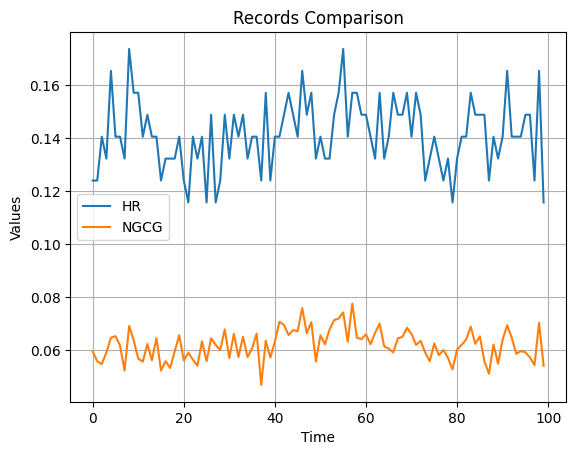

In [17]:
import matplotlib.pyplot as plt

# x축 데이터 (시간이나 인덱스 등)
x = range(len(records_hr))

# 꺽은선 그래프 그리기
plt.plot(x, records_hr, label='HR'
  #, marker='o'
  )
plt.plot(x, records_ngcg, label='NGCG'
  #, marker='s'
  )

# 그래프 제목 및 축 레이블
plt.title('Records Comparison')
plt.xlabel('Time')
plt.ylabel('Values')

# 범례 추가
plt.legend()

# 그래프 보여주기
plt.grid()
plt.show()

In [18]:
torch.save(model.state_dict(), root_path + 'BPR.pt')

## 테스트

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BPRNN(user_num, item_num, num_factors)
model.to(device)
model.load_state_dict(torch.load(root_path + 'BPR.pt'))
model.eval()

<ipython-input-19-9593257bf9d8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(root_path + 'BPR.pt'))


BPRNN(
  (user_factors): Embedding(12063, 32)
  (item_factors): Embedding(7012, 32)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [20]:
def recommend_restaurants(user_id, model, train_mat, item_num, top_k=10):
    """
    Arg:
    - user_id (int): 추천을 받을 사용자 ID.
    - model (torch.nn.Module): 학습된 BPR 모델.
    - train_mat (scipy.sparse.dok_matrix): 사용자-아이템 희소 행렬, 이미 방문한 음식점 확인에 사용
    - item_num (int): 전체 아이템(음식점) 수.
    - top_k (int): 추천받을 음식점의 수.

    Returns:
    - top_k_items (list of int): 추천된 상위 음식점 ID 리스트.
    """
    # 모든 아이템(음식점)을 대상으로 평가
    item_ids = torch.tensor(range(item_num)).to(device)

    # 사용자 임베딩과 아이템 임베딩을 계산
    user_embedding = model.user_factors(torch.tensor([user_id]).to(device))
    item_embeddings = model.item_factors(item_ids)

    # 내적(matmul)을 통해 각 음식점에 대한 점수 산출 ( [user_embedding * d] [d* item_embeddings] ) ".t()"를 통해 전치행렬로 변환
    # squeeze(0)을 통해 1차원 벡터로 변환 / cpu() - GPU에 있는 텐서를 CPU로 옮김
    scores = torch.matmul(user_embedding, item_embeddings.t()).squeeze(0).cpu().detach().numpy()

    # 이미 방문한 음식점은 추천에서 제외
    print(train_mat[user_id].keys())
    already_visited = list(train_mat[user_id].keys())
    for visited_item in already_visited:
        scores[visited_item[1]] = -np.inf  # 이미 방문한 음식점의 점수를 -무한대로 설정

    # 상위 top_k 음식점을 추출
    top_k_items = np.argsort(scores)[-top_k:][::-1]  # 점수가 높은 순서대로 정렬

    return top_k_items


# 사용자 n에 대해 상위 10개 음식점을 추천
user_id = 3789  # 추천할 사용자 ID
top_k_items = recommend_restaurants(user_id, model, train_mat, item_num, top_k=10)

print(f"Top {len(top_k_items)} 추천 음식점 for 사용자 {user_id}: {top_k_items}")

dict_keys([(0, 50), (0, 64), (0, 75), (0, 94), (0, 211), (0, 292), (0, 325), (0, 333), (0, 361), (0, 484), (0, 503), (0, 614), (0, 683), (0, 756), (0, 781), (0, 952), (0, 975), (0, 1029), (0, 1033), (0, 1076), (0, 1135), (0, 1161), (0, 1212), (0, 1393), (0, 1430), (0, 1483), (0, 1504), (0, 1506), (0, 1841), (0, 1869), (0, 1993), (0, 2000), (0, 2074), (0, 2514), (0, 2923), (0, 3549)])
Top 10 추천 음식점 for 사용자 3789: [ 800 3296 4804 1501 4996 4238 4830 4114 1779 3640]
